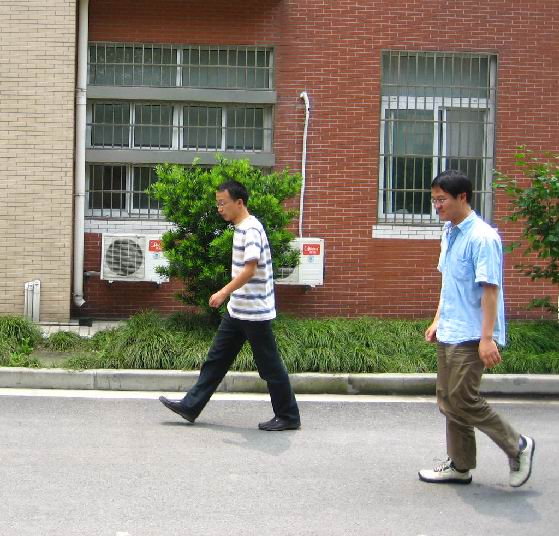

In [27]:
from PIL import Image
Image.open('D:\Machine_Learning\maskrcnn_pytorch\PennFudanPed\PNGImages\FudanPed00001.png')

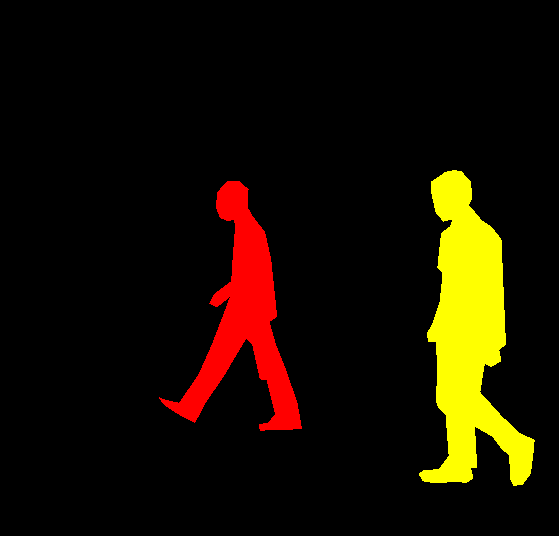

In [26]:
import numpy as np
mask = Image.open("D:\Machine_Learning\maskrcnn_pytorch\PennFudanPed\PedMasks\FudanPed00001_mask.png")

mask = mask.convert('P')

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
    200,200,200, # index 4
])
mask

## Create Manual Mask from PedestrianDataset Datasets

In [69]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2

dir_list = os.listdir(r"D:\Machine_Learning\maskrcnn_pytorch\PennFudanPed\PedMasks")

# Parent Directory path
parent_dir = r"D:\Machine_Learning\maskrcnn_pytorch\PennFudanPed\Mask"

for image_mask_name in dir_list:
    # Directory
    directory = image_mask_name[:-4]

    # Path
    path = os.path.join(parent_dir, directory)
    print(path)
    try:
        os.makedirs(path, exist_ok = True)
        print("Directory '%s' created successfully" % directory)
    except OSError as error:
        print("Directory '%s' can not be created" % directory)

    path = os.path.join(parent_dir, directory,"class_1")
    print(path)
    try:
        os.makedirs(path, exist_ok = True)
        print("Directory '%s' created successfully" % directory)
    except OSError as error:
        print("Directory '%s' can not be created" % directory)

    mask_path = "D:\Machine_Learning\maskrcnn_pytorch\PennFudanPed\PedMasks\\"+image_mask_name
    mask = Image.open(mask_path)
    
    mask = np.array(mask)
    obj_ids = np.unique(mask)
    obj_ids = obj_ids[1:]

    mask_split = mask == obj_ids[:, None, None]

    masks_tensor = torch.as_tensor(mask_split, dtype=torch.uint8)
    print(masks_tensor.shape)
    break
    # for idx,mask_obj in enumerate(masks_tensor):
    #     cv2.imwrite(path+"\\"+str(idx)+"_"+image_mask_name, mask_obj.numpy()*255)


D:\Machine_Learning\maskrcnn_pytorch\PennFudanPed\Mask\FudanPed00001_mask
Directory 'FudanPed00001_mask' created successfully
D:\Machine_Learning\maskrcnn_pytorch\PennFudanPed\Mask\FudanPed00001_mask\class_1
Directory 'FudanPed00001_mask' created successfully
torch.Size([2, 536, 559])


## Custom Class mask

In [26]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class PedestrianDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Mask"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        label_list = []
        mask_list = []
        for mask_class in os.listdir(os.path.join(self.root, "Mask", self.masks[idx])):
            for mask_path in os.listdir(os.path.join(self.root, "Mask", self.masks[idx],mask_class)):
                mask = Image.open(os.path.join(self.root, "Mask", self.masks[idx],mask_class,mask_path))
                mask = np.array(mask)
                mask = mask == 255
    
                # Binary Mask 0 1
                pos = np.where(mask)
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])
                label_list.append(int(mask_class[-1]))
                mask_list.append(mask)
         
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(label_list, dtype=torch.int64)

        masks = torch.as_tensor(np.bool_(mask_list), dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros(len(labels), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="MaskRCNN_ResNet50_FPN_Weights.COCO_V1")

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [28]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = PedestrianDataset('PennFudanPed', get_transform(train=True))
dataset_test = PedestrianDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [34]:
import time

# number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
timestr = time.strftime("%Y%m%d-%H%M%S")
torch.save(model, 'model/mask-rcnn-pedestrian-'+str(num_epochs)+'-'+timestr+'.pt')

Epoch: [0]  [ 0/60]  eta: 0:00:30  lr: 0.000090  loss: 0.1627 (0.1627)  loss_classifier: 0.0144 (0.0144)  loss_box_reg: 0.0441 (0.0441)  loss_mask: 0.1016 (0.1016)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 0.5089  data: 0.2967  max mem: 3487
Epoch: [0]  [10/60]  eta: 0:00:10  lr: 0.000936  loss: 0.1954 (0.2172)  loss_classifier: 0.0297 (0.0276)  loss_box_reg: 0.0441 (0.0528)  loss_mask: 0.1122 (0.1317)  loss_objectness: 0.0010 (0.0016)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 0.2182  data: 0.0334  max mem: 3487
Epoch: [0]  [20/60]  eta: 0:00:08  lr: 0.001783  loss: 0.1954 (0.2050)  loss_classifier: 0.0274 (0.0261)  loss_box_reg: 0.0431 (0.0484)  loss_mask: 0.1128 (0.1251)  loss_objectness: 0.0010 (0.0020)  loss_rpn_box_reg: 0.0026 (0.0034)  time: 0.1890  data: 0.0070  max mem: 3487
Epoch: [0]  [30/60]  eta: 0:00:06  lr: 0.002629  loss: 0.1755 (0.2115)  loss_classifier: 0.0274 (0.0283)  loss_box_reg: 0.0370 (0.0527)  loss_mask: 0.1104 (0.1249)  loss_ob

In [3]:
model = torch.load('model/mask-rcnn-pedestrian-10-20220811-123047.pt')
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'pedestrian']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [1]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=0.5, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(len(masks))
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

      cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])),color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    
    
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

2022-08-11 12:34:18 URL:https://storage.needpix.com/rsynced_images/pedestrian-zone-456909_1280.jpg [409534/409534] -> "pedestrian.jpg" [1]


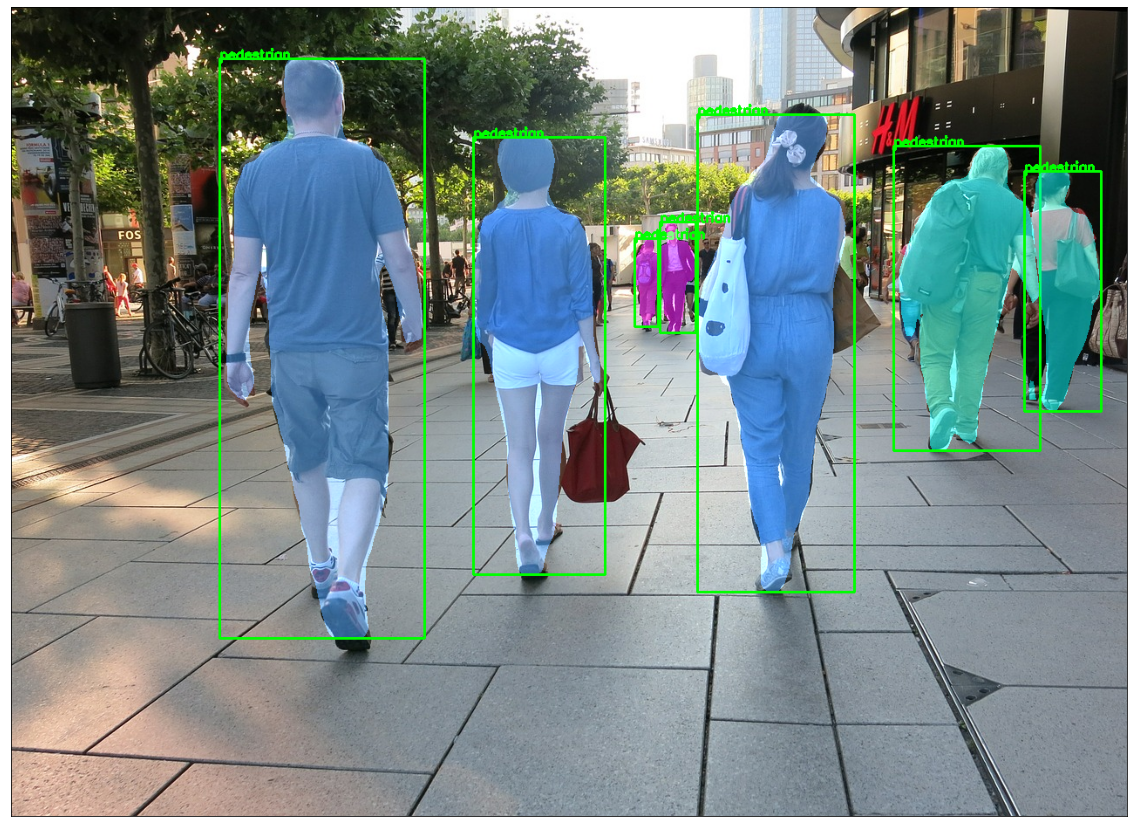

In [40]:
!wget -nv https://storage.needpix.com/rsynced_images/pedestrian-zone-456909_1280.jpg -O pedestrian.jpg
segment_instance('./pedestrian.jpg', confidence=0.7)

7


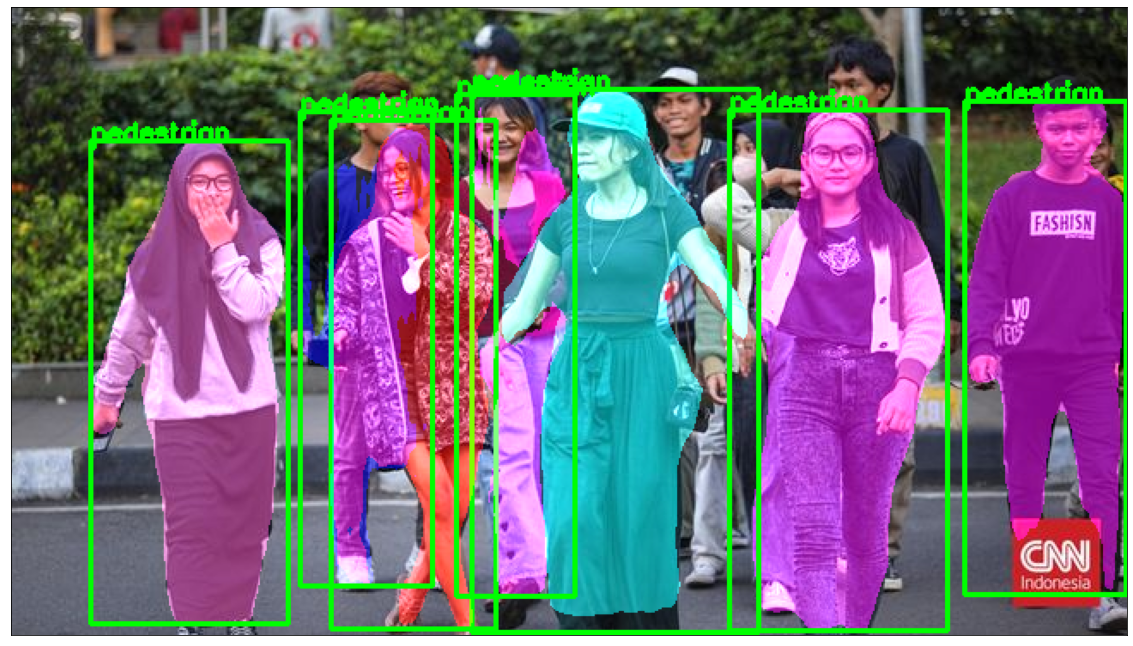

In [4]:
segment_instance('./street-fashion-sudirman-12_169.jpeg', confidence=0.7)

3


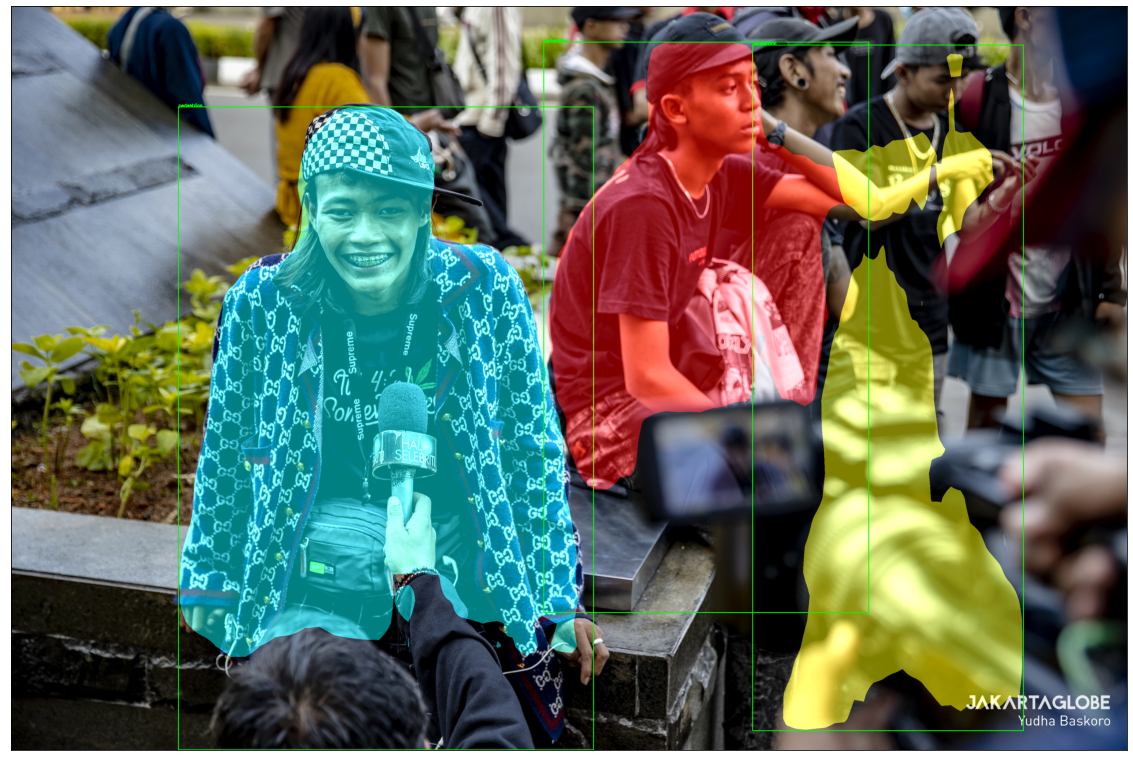

In [5]:
segment_instance('./bonge_smile.jpeg', confidence=0.7)